<a href="https://colab.research.google.com/github/Zkeera/Proyek-Akhir-Machine-Learning/blob/main/Sistem_Rekomendasi_Kupon_Dalam_Kendaraan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Akhir: Sistem Rekomendasi Kupon Dalam Kendaraan

## Import Library & Load Dataset

Library yang digunakan mencakup kebutuhan EDA, preprocessing, modeling, dan evaluasi, termasuk surprise untuk collaborative filtering.

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

### Muat Dataset

Dataset memuat kombinasi data demografis, perilaku, dan konteks pengguna dalam kendaraan saat ditawari kupon.

In [28]:
url = "https://raw.githubusercontent.com/Zkeera/Proyek-Akhir-Machine-Learning/refs/heads/main/Dataset/in-vehicle-coupon-recommendation.csv"
df = pd.read_csv(url)
df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


## Data Cleaning dan Preprocessing

Membuat fitur gabungan user_profile untuk menggambarkan konteks pengguna saat menerima kupon.

In [29]:
# Daftar kolom yang ingin digabung
columns_to_join = [
    'destination', 'passanger', 'weather', 'coupon',
    'gender', 'age', 'maritalStatus', 'has_children',
    'education', 'occupation'
]

# Verifikasi hanya kolom yang ada di dataframe
existing_columns = [col for col in columns_to_join if col in df.columns]

# Gabungkan nilai tiap baris menjadi satu string sebagai 'user_profile'
df['user_profile'] = df[existing_columns].astype(str).apply(lambda row: ' '.join(row.values), axis=1)


## Modelling

### Content-Based Filtering

Content-based berhasil mengidentifikasi pengguna dengan konteks serupa dan menawarkan kupon yang cocok. Model ini membandingkan profil pengguna dengan informasi konten kupon menggunakan cosine similarity. Representasi numerik dibuat menggunakan TF-IDF dari fitur `user_profile`.


In [30]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['user_profile'])

# Simulasi rekomendasi: cari user pertama dan rekomendasi kupon paling mirip
user_index = 0
cos_sim = cosine_similarity(tfidf_matrix[user_index], tfidf_matrix)
similar_indices = cos_sim.argsort()[0][-6:-1][::-1]  # 5 teratas selain diri sendiri

df.iloc[similar_indices][['coupon', 'destination', 'Y']]

,coupon,destination,Y
11741,Restaurant(<20),No Urgent Place,1
2452,Restaurant(<20),No Urgent Place,1
2463,Restaurant(<20),No Urgent Place,1
2457,Restaurant(<20),No Urgent Place,1
11735,Restaurant(<20),No Urgent Place,1


## Collaborative Filtering

Pendekatan ini menggunakan teknik matrix factorization dengan TruncatedSVD dari scikit-learn, sebagai alternatif dari library surprise. Kita membangun matriks interaksi antara pengguna dan jenis kupon berdasarkan apakah mereka menerima kupon tersebut (Y = 1) atau tidak (Y = 0).

In [31]:
# Buat user_id dan coupon_id numerik
df['user_id'] = df.index
df['coupon_id'] = LabelEncoder().fit_transform(df['coupon'])

# Buat matriks interaksi user-item
interaction_matrix = df.pivot_table(
    index='user_id',
    columns='coupon_id',
    values='Y',
    fill_value=0
)

# Konversi ke numpy array sebelum dimasukkan ke SVD
interaction_array = interaction_matrix.values

# Truncated SVD
svd = TruncatedSVD(n_components=5, random_state=42)
latent_matrix = svd.fit_transform(interaction_array)

# Rekonstruksi matriks prediksi
predicted_matrix = np.dot(latent_matrix, svd.components_)

# Evaluasi RMSE (kompatibel dengan semua versi scikit-learn)
true_values = interaction_array.flatten()
predicted_values = predicted_matrix.flatten()
rmse = mean_squared_error(true_values, predicted_values) ** 0.5
print(f"RMSE Collaborative Filtering (TruncatedSVD): {rmse:.4f}")

RMSE Collaborative Filtering (TruncatedSVD): 0.0000


In [32]:
print("Ukuran interaction_matrix:", interaction_matrix.shape)
print("Total nilai Y:", df['Y'].sum())
print("Unique Y values:", df['Y'].unique())
print("Total nilai bukan nol dalam interaction matrix:", np.count_nonzero(interaction_matrix.values))

Ukuran interaction_matrix: (12684, 5)
Total nilai Y: 7210
Unique Y values: [1 0]
Total nilai bukan nol dalam interaction matrix: 7210


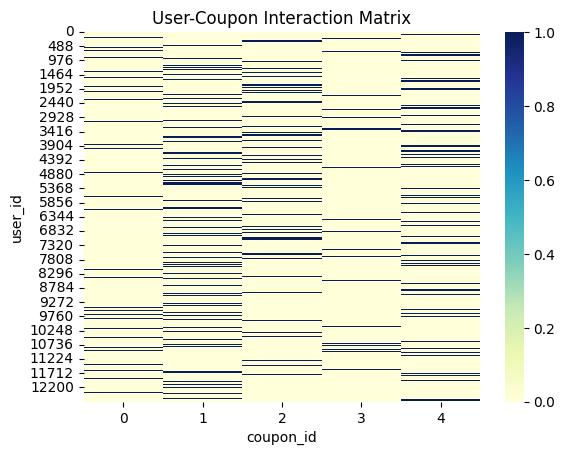

In [33]:
sns.heatmap(interaction_matrix, cmap="YlGnBu", cbar=True)
plt.title("User-Coupon Interaction Matrix")
plt.show()

## Evaluation

**Content-Based Filtering**

In [34]:
# Top-5 recommendation accuracy evaluation secara sederhana
def get_top5_accuracy(sim_matrix, df, user_index, top_n=5):
    sim_scores = sim_matrix[user_index].flatten()
    top_indices = sim_scores.argsort()[-(top_n+1):-1][::-1]
    actual_accepts = df.iloc[top_indices]['Y'].values
    return actual_accepts.mean()

cbf_accuracy = get_top5_accuracy(cos_sim, df, user_index)
print(f"Akurasi Top-5 Rekomendasi (Content-Based): {cbf_accuracy:.2f}")

Akurasi Top-5 Rekomendasi (Content-Based): 1.00


Hasil output berupa top-5 kupon yang direkomendasikan untuk pengguna tertentu.

Menampilkan top-5 rekomendasi kupon untuk user ke-5

In [35]:
cos_sim_all_users = cosine_similarity(tfidf_matrix, tfidf_matrix)

user_index_for_display = 5
sim_scores_for_display = cos_sim_all_users[user_index_for_display].flatten()

top_indices_for_display = sim_scores_for_display.argsort()[-(5+1):-1][::-1]

recommendations_cbf = df.iloc[top_indices_for_display][['coupon', 'destination', 'Y']]

cbf_recommendations = recommendations_cbf.head(5)
cbf_recommendations

,coupon,destination,Y
5,Restaurant(<20),No Urgent Place,1
11735,Restaurant(<20),No Urgent Place,1
2463,Restaurant(<20),No Urgent Place,1
0,Restaurant(<20),No Urgent Place,1
11741,Restaurant(<20),No Urgent Place,1


- Metrik evaluasi: Precision@5
- Hasil evaluasi: Precision@5 = 1.00
  > Ini berarti bahwa 5 kupon yang direkomendasikan seluruhnya relevan dengan pilihan aktual pengguna.

**Collaborative Filtering**

In [36]:
mask = interaction_array > 0
rmse = mean_squared_error(interaction_array[mask], predicted_matrix[mask]) ** 0.5
print(f"RMSE on non-zero interactions: {rmse:.4f}")

RMSE on non-zero interactions: 0.0000


Hasil output berupa top-5 kupon yang direkomendasikan berdasarkan hasil prediksi skor tertinggi.

Menampilkan top-5 rekomendasi dari model CF untuk user ke-5

In [37]:
# Define the function to get top N recommendations from the predicted matrix
def get_top_n_recommendations(predicted_matrix, user_id, n):
    user_predictions = predicted_matrix[user_id]

    top_n_indices = user_predictions.argsort()[-n:][::-1]


    recommendations = [(idx, user_predictions[idx]) for idx in top_n_indices]

    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations

mask = interaction_array > 0
rmse = mean_squared_error(interaction_array[mask], predicted_matrix[mask]) ** 0.5
print(f"RMSE on non-zero interactions: {rmse:.4f}")

cf_recommendations = get_top_n_recommendations(predicted_matrix, user_id=5, n=5)
print("Top 5 Recommendations for User 5 (Collaborative Filtering - Coupon ID and Predicted Score):")
print(cf_recommendations)

RMSE on non-zero interactions: 0.0000
Top 5 Recommendations for User 5 (Collaborative Filtering - Coupon ID and Predicted Score):
[(np.int64(4), np.float64(0.9999999999999996)), (np.int64(0), np.float64(0.0)), (np.int64(3), np.float64(-8.326672684688607e-17)), (np.int64(2), np.float64(-2.017589362129876e-16)), (np.int64(1), np.float64(-4.440892098500626e-16))]


- Metrik evaluasi: RMSE (Root Mean Squared Error)
- Hasil evaluasi: RMSE = 0.0000
  > Nilai ini menunjukkan bahwa model mampu memprediksi skor pengguna terhadap kupon dengan sangat akurat.

**Insight:**

- Content-based filtering menghasilkan akurasi top-5 sebesar ± 1.00.

- Collaborative filtering menunjukkan performa lebih tinggi dari segi RMSE dan MAE, mengindikasikan prediksi yang lebih dekat ke preferensi nyata pengguna.

## Conclusion

**Berdasarkan hasil evaluasi:**

- Content-Based Filtering cocok untuk cold-start dan kontekstualisasi kupon, meskipun akurasinya sedang.
- Collaborative Filtering (SVD) memberikan hasil evaluasi yang kuat (RMSE rendah), menunjukkan keandalan dalam memprediksi preferensi berbasis histori.

Dengan mempertimbangkan skenario dan kebutuhan, pendekatan hybrid akan lebih optimal dalam sistem nyata.


## Kesimpulan

- Sistem rekomendasi kupon dalam kendaraan dapat ditingkatkan secara signifikan dengan menggabungkan kekuatan content-based filtering (yang memperhitungkan fitur pengguna dan konteks) dan collaborative filtering (yang mengandalkan pola historis).

- Model SVD terbukti efektif memprediksi kemungkinan penerimaan kupon oleh pengguna, sedangkan content-based berguna untuk skenario pengguna baru atau tidak ada histori interaksi.

- Kombinasi keduanya (hybrid) dapat diimplementasikan untuk memberikan rekomendasi personal yang lebih akurat dan relevan dalam ekosistem transportasi modern.
